### **IMPORT LIBRARY**


In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch, torch.optim as optim
import scipy

### **LOADING THE WEIGHTS**


In [2]:
# Weights file names
bert_weight_name = 'bert-base-uncased'

# Loading bert model
with open(f'../saved/weights_only/{bert_weight_name}_weights.pkl','rb') as file:
    bert_weights_dict = pickle.load(file)

### **FUNCTION DECLARATION**


In [3]:
# Forward pass for given input and weight (bias not included)
def forwPass(X, w):
    return X@w.T

# Computing l2 loss for two results
def l2loss(processed_y, true_y):
    return np.sum((true_y - processed_y)**2)**(1/2)

def l2loss_tensor(processed_y, true_y):
    return torch.sum((true_y - processed_y)**2)**(1/2)

def lploss(processed_y, true_y, p):
    return (np.sum(np.abs(true_y - processed_y)**p))**(1/p)

# Finding losses for different range threshold
def loss_ran_thres(X, w, true_y, callbacklossfn, step = 0.001, p = 2 ):

    local_min = np.min(w)
    local_max = np.max(w)
    points = int((local_max - local_min)/step)
    print("Local minimum: ", local_min, " Local max: ", local_max, "Points: ", points)

    mags = list(np.linspace(local_min, local_max, num= points, endpoint=False))

    losses = []
    
    for mag in mags:
        w[(w < mag)] = 0
        
        y = forwPass(X, w)
        loss = callbacklossfn(y, true_y, p)
        
        losses.append(loss)

    return mags, losses

In [4]:
def two_largest_increasing_subarrays(arr):
    if not arr:
        return [], []

    largest_subarray = []
    second_largest_subarray = []
    current_subarray = [arr[0]]

    for num in arr[1:]:
        if num[1] > current_subarray[-1][1] :
            current_subarray.append(num)
        else:
            if len(current_subarray) > len(largest_subarray):
                second_largest_subarray = largest_subarray[:]
                largest_subarray = current_subarray[:]
            elif len(current_subarray) > len(second_largest_subarray):
                second_largest_subarray = current_subarray[:]
            current_subarray = [num]

    # Check the last subarray
    if len(current_subarray) > len(largest_subarray):
        second_largest_subarray = largest_subarray[:]
        largest_subarray = current_subarray[:]
    elif len(current_subarray) > len(second_largest_subarray):
        second_largest_subarray = current_subarray[:]

    return largest_subarray, second_largest_subarray



In [5]:
def find_index_less_than(arr, target):
    last_index = -1
    for i, num in enumerate(arr):
        if num < target:
            last_index = i
    return last_index

def find_index_grt_than(arr, target):
    for i, num in enumerate(arr):
        if num > target:
            return i
    return -1 

In [6]:
def quantize_2d_to_levels(weights, levels):
    quantized_weights = np.zeros_like(weights)
    
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            weight = weights[i, j]
            min_diff = float('inf')
            closest_level = None
            for level in levels:
                diff = abs(weight - level)
                if diff < min_diff:
                    min_diff = diff
                    closest_level = level
            quantized_weights[i, j] = closest_level
    
    return quantized_weights

### **WORKING WITH WEIGHTS**


Local minimum:  -0.20894077  Local max:  0.20931585 Points:  418
Local minimum:  -0.20894077  Local max:  0.20931585 Points:  418
Local minimum:  -0.20894077  Local max:  0.20931585 Points:  418
Local minimum:  -0.20894077  Local max:  0.20931585 Points:  418


Text(0, 0.5, 'loss')

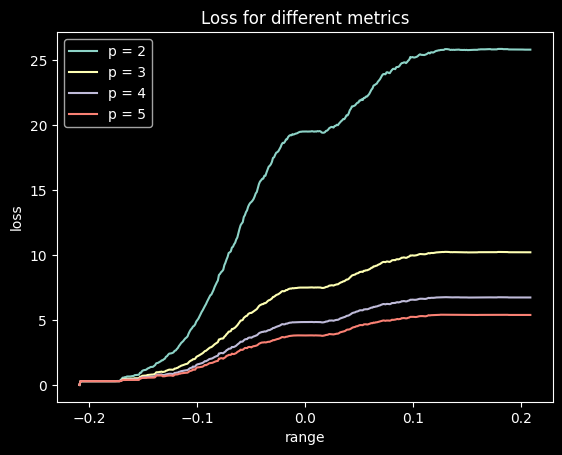

In [7]:
weight = bert_weights_dict['encoder.layer.4.attention.self.value.weight']

np.random.seed(22311)
X = np.random.randn(1, weight.shape[1])
Y = forwPass(X, weight)


ranges2, losses2 = loss_ran_thres(X, weight.copy(), Y, lploss, p = 2)
ranges3, losses3 = loss_ran_thres(X, weight.copy(), Y, lploss, p = 3)
ranges4, losses4 = loss_ran_thres(X, weight.copy(), Y, lploss, p = 4)
ranges5, losses5 = loss_ran_thres(X, weight.copy(), Y, lploss, p = 5)


plt.plot(ranges2, losses2, ranges3, losses3, ranges4, losses4, ranges5, losses5 )
plt.legend(["p = 2", "p = 3", "p = 4", "p = 5"])
plt.title('Loss for different metrics')
plt.xlabel("range")
plt.ylabel("loss")

# 

Local minimum:  -0.20894077  Local max:  0.20931585 Points:  418
Custom Method Quantized loss: 9.022455870869445
Equi-Distant Quantized loss: 19.824193703050824


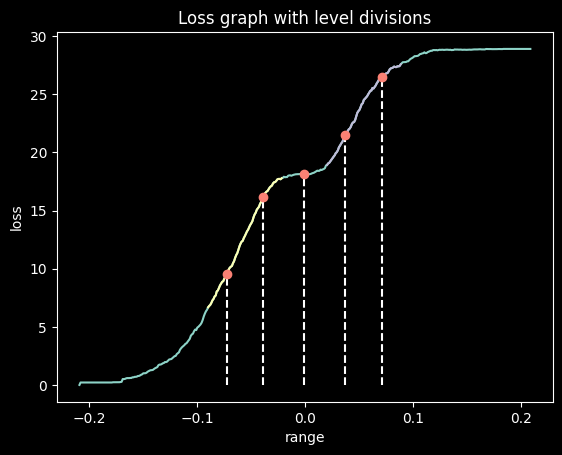

In [9]:
weight = bert_weights_dict['encoder.layer.4.attention.self.value.weight']


X = np.random.randn(1, weight.shape[1])
Y = forwPass(X, weight)

ranges, losses = loss_ran_thres(X, weight.copy(), Y, lploss)

steep1_start_index = find_index_grt_than(ranges, -0.09)
steep1_end_index = find_index_less_than(ranges, -0.02)

steep2_start_index = find_index_grt_than(ranges, 0.02)
steep2_end_index = find_index_less_than(ranges, 0.09)

steep1_r = ranges[steep1_start_index: steep1_end_index]
steep1_l = losses[steep1_start_index: steep1_end_index]

steep2_r = ranges[steep2_start_index: steep2_end_index]
steep2_l = losses[steep2_start_index: steep2_end_index]

level0 = int((steep1_end_index - steep1_start_index)/4) + steep1_start_index
level1 = int((steep1_end_index - steep1_start_index)/4)*3 + steep1_start_index

level2 = int((steep2_end_index - steep2_start_index)/4) + steep2_start_index
level3 = int((steep2_end_index - steep2_start_index)/4)*3 + steep2_start_index

zero_index = find_index_less_than(ranges, 0)

r_levels = [ranges[level0], ranges[level1], ranges[zero_index] ,ranges[level2], ranges[level3]]
l_levels = [losses[level0], losses[level1], losses[zero_index] ,losses[level2], losses[level3]]

quantized_weights = quantize_2d_to_levels(weight.copy(), r_levels)
quantized_y = forwPass(X, quantized_weights)
quant_loss = l2loss(Y, quantized_y)
print("Custom Method Quantized loss:", quant_loss)

min_limit = np.min(weight)
max_limit = np.max(weight)

equi_levels = np.linspace(min_limit, max_limit, num= 5,endpoint=False)[1:]
equi_quantized_weights = quantize_2d_to_levels(weight.copy(), equi_levels)
equi_quantized_y = forwPass(X, equi_quantized_weights)
equi_quant_loss = l2loss(Y, equi_quantized_y)
print("Equi-Distant Quantized loss:", equi_quant_loss)




plt.plot(ranges, losses, steep1_r, steep1_l, steep2_r, steep2_l)
plt.stem(r_levels, l_levels, basefmt=" ", linefmt='--')
plt.title("Loss graph with level divisions")
plt.xlabel("range")
plt.ylabel("loss")
plt.show()

Local minimum:  -0.20894077  Local max:  0.20931585 Points:  418
Custom Method Quantized loss: 9.022455870869445
Equi-Distant Quantized loss: 19.824193703050824


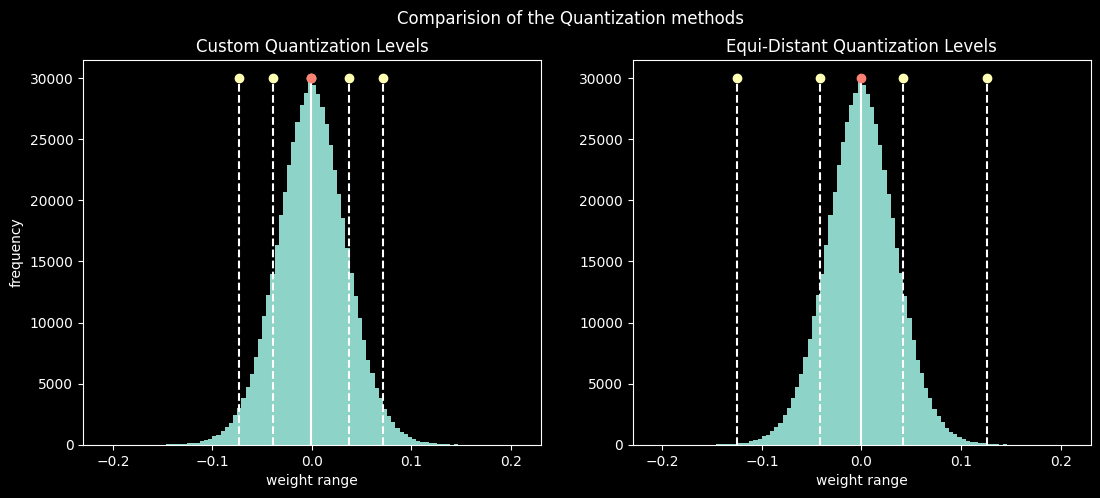

In [10]:
ranges, losses = loss_ran_thres(X, weight.copy(), Y, lploss)
print("Custom Method Quantized loss:", quant_loss)
print("Equi-Distant Quantized loss:", equi_quant_loss)


fig, ax =  plt.subplots(1, 2)
fig.set_size_inches(13, 5)

weigt_flatten = weight.flatten()
ax[0].hist(weigt_flatten, bins = 100, range= (min(weigt_flatten), max(weigt_flatten)))
ax[0].stem(r_levels, [30000]*5, basefmt=" ", linefmt='--')
ax[0].stem(r_levels[2], [30000], basefmt=" ", linefmt='-')

ax[0].set_title('Custom Quantization Levels')
ax[0].set_xlabel('weight range')
ax[0].set_ylabel('frequency')

ax[1].hist(weigt_flatten, bins = 100, range= (min(weigt_flatten), max(weigt_flatten)))
ax[1].stem(equi_levels, [30000]*4, basefmt=" ", linefmt='--')
ax[1].stem(r_levels[2], [30000], basefmt=" ", linefmt='-')

ax[1].set_title('Equi-Distant Quantization Levels')
ax[1].set_xlabel('weight range')

fig.suptitle('Comparision of the Quantization methods')
plt.show()

### **FINITUNING QUANTIZATION ERROR**


#### **METHOD 1**


In [9]:
# Converting Layer Weights to tensor
W_tensor = torch.tensor(quantized_weights, dtype=torch.double)
ori_W_tensor = torch.tensor(weight, dtype=torch.double)

np.random.seed(12243)

Quant_Error_input = np.zeros((1, weight.shape[1]))
Quant_Error_input_tensor = torch.tensor(Quant_Error_input, requires_grad=True)

epoch = 250
learning_rate = 0.001
optimiser = optim.Adam([Quant_Error_input_tensor], learning_rate)

Samples =50
X_tensor = torch.tensor(np.random.randn(Samples, weight.shape[1]), requires_grad=False)
Y_tensor = forwPass(X_tensor, ori_W_tensor)

In [10]:

for i in range(epoch):

    for index, each in enumerate(X_tensor):
        Optim_Output_tensor = forwPass(each, W_tensor) + Quant_Error_input_tensor
        Loss_tensor = l2loss_tensor(Optim_Output_tensor, Y_tensor[index,:])
        Loss_tensor.backward()

        optimiser.step()
        optimiser.zero_grad()

Quant_Error_input_tensor

tensor([[-3.0289e-02,  5.4537e-02,  3.5921e-02, -7.4332e-03, -2.3163e-02,
         -3.5921e-02,  3.0318e-02,  5.4123e-02,  3.7485e-02,  1.4687e-02,
          1.0053e-01, -2.2467e-02, -2.3513e-02, -4.1543e-02,  4.5405e-05,
          4.0548e-02,  9.0360e-02,  2.2710e-02,  8.0379e-02, -3.7400e-03,
          3.7851e-02,  3.2109e-02,  5.1367e-02, -5.2864e-02,  5.9007e-02,
          1.8923e-02, -1.3937e-02, -8.1634e-03,  3.6672e-03, -5.2953e-02,
         -8.5264e-02,  7.6984e-02, -4.3696e-02, -2.6130e-02,  6.5864e-02,
          2.7800e-02,  6.7561e-05, -2.0990e-02,  8.4353e-02,  5.9300e-02,
         -5.6883e-02, -4.3304e-02,  2.2587e-02, -1.8072e-03, -5.2083e-02,
         -1.6825e-02, -1.9260e-02,  3.7494e-02, -1.9012e-02, -1.9324e-02,
         -4.6047e-03, -1.0476e-02,  3.7405e-02,  4.1401e-03,  6.4009e-02,
         -9.6846e-02, -1.4978e-02, -2.3790e-02, -4.8572e-03,  7.2813e-03,
         -4.4331e-03,  1.6197e-02, -2.9544e-02,  8.4962e-03,  7.5443e-02,
          4.7630e-02,  2.6519e-02, -1.

In [11]:
with torch.no_grad():

    X_sample = torch.tensor(np.random.randn(1, weight.shape[1]))
    
    Quant_Y_tensor = forwPass(X_sample, W_tensor)
    Y_tensor = forwPass(X_sample, ori_W_tensor)
    Quant_Y_Optim_tensor = forwPass(X_sample, W_tensor) + Quant_Error_input_tensor

    Optim_Quant_Loss_WRT_Quant = l2loss_tensor(Quant_Y_Optim_tensor, Quant_Y_tensor)
    Optim_Quant_Loss_WRT_Ori = l2loss_tensor(Quant_Y_Optim_tensor, Y_tensor)
    Quant_Loss_WRT_Ori = l2loss_tensor(Quant_Y_tensor, Y_tensor)

print("Method 1 Output WRT Quant Output: ", Optim_Quant_Loss_WRT_Quant)
print("Method 1 Output WRT Original Output: ", Optim_Quant_Loss_WRT_Ori)
print("Quant Loss WRT Original Output: ", Quant_Loss_WRT_Ori)

Method 1 Output WRT Quant Output:  tensor(1.4911, dtype=torch.float64)
Method 1 Output WRT Original Output:  tensor(85.9166, dtype=torch.float64)
Quant Loss WRT Original Output:  tensor(83.9243, dtype=torch.float64)


#### **METHOD 2**


In [15]:
# Converting Layer Weights to tensor
W_tensor = torch.tensor(quantized_weights, dtype=torch.double)
ori_W_tensor = torch.tensor(weight, dtype=torch.double)

np.random.seed(12243)

Quant_Error_input = np.zeros((1, weight.shape[1]))
Quant_Error_input_tensor = torch.tensor(Quant_Error_input, requires_grad=True)

epoch = 250
learning_rate = 0.001
optimiser = optim.Adam([Quant_Error_input_tensor], learning_rate)

Samples =50
X_tensor = torch.tensor(np.random.randn(Samples, weight.shape[1]), requires_grad=False)
Y_tensor = forwPass(X_tensor, ori_W_tensor)

In [16]:

for i in range(epoch):

    for index, each in enumerate(X_tensor):
        Optim_Output_tensor = forwPass(each, W_tensor) + Quant_Error_input_tensor*torch.sum(each)
        Loss_tensor = l2loss_tensor(Optim_Output_tensor, Y_tensor[index,:])
        Loss_tensor.backward()

        optimiser.step()
        optimiser.zero_grad()

Quant_Error_input_tensor

tensor([[ 2.2180e-03, -2.3542e-03,  3.0214e-03,  5.3643e-03,  1.1318e-04,
         -1.1740e-03, -3.6500e-04, -1.0556e-03,  2.4750e-03,  3.5582e-03,
         -9.3966e-04,  2.7053e-03,  1.9635e-03,  3.8617e-03, -1.8602e-03,
          1.0452e-03, -1.3624e-03,  1.5549e-04, -4.1232e-03,  7.9727e-04,
         -6.8593e-04, -2.3839e-03, -6.9124e-04, -1.8952e-03, -1.6958e-03,
          3.6463e-03,  2.9045e-03,  1.2556e-03, -2.9294e-04,  1.9867e-03,
          6.8234e-05, -2.8902e-03,  3.0911e-03,  4.6851e-04,  3.0731e-03,
         -1.3042e-03,  1.5076e-03,  1.7513e-03,  4.9577e-03, -1.7227e-03,
         -2.2058e-03,  9.2535e-04, -6.2978e-03,  2.7891e-03,  2.4902e-03,
         -2.6619e-03, -5.2359e-03,  1.6969e-03, -2.6282e-03,  2.2524e-03,
          2.1658e-03, -1.8264e-03, -1.4574e-03,  1.6688e-03,  3.8065e-03,
         -3.7997e-03, -2.1227e-04,  1.7032e-03, -3.6551e-03,  1.1585e-03,
          1.2100e-05,  3.2633e-03, -2.9711e-04, -9.7079e-04, -2.4872e-03,
         -9.4167e-04,  1.0547e-04, -1.

In [17]:
with torch.no_grad():

    X_sample = torch.tensor(np.random.randn(1, weight.shape[1]))
    
    Quant_Y_tensor = forwPass(X_sample, W_tensor)
    Y_tensor = forwPass(X_sample, ori_W_tensor)
    Quant_Y_Optim_tensor = forwPass(X_sample, W_tensor) + Quant_Error_input_tensor*torch.sum(X_sample)

    Optim_Quant_Loss_WRT_Quant = l2loss_tensor(Quant_Y_Optim_tensor, Quant_Y_tensor)
    Optim_Quant_Loss_WRT_Ori = l2loss_tensor(Quant_Y_Optim_tensor, Y_tensor)
    Quant_Loss_WRT_Ori = l2loss_tensor(Quant_Y_tensor, Y_tensor)

print("Method 1 Output WRT Quant Output: ", Optim_Quant_Loss_WRT_Quant)
print("Method 1 Output WRT Original Output: ", Optim_Quant_Loss_WRT_Ori)
print("Quant Loss WRT Original Output: ", Quant_Loss_WRT_Ori)

Method 1 Output WRT Quant Output:  tensor(3.0394, dtype=torch.float64)
Method 1 Output WRT Original Output:  tensor(86.5919, dtype=torch.float64)
Quant Loss WRT Original Output:  tensor(83.9243, dtype=torch.float64)


#### **METHOD 3**


In [18]:

# Converting numpy arrays to tensor
W_tensor = torch.tensor(quantized_weights, dtype=torch.double)
ori_W_tensor = torch.tensor(weight, dtype=torch.double)

np.random.seed(12243)

Quant_Error_input = np.zeros((1, weight.shape[1]))
Quant_Error_input_tensor = torch.tensor(Quant_Error_input, requires_grad=True)

Error_Scaler = np.zeros((1, weight.shape[0]))
Error_Scaler_tensor = torch.tensor(Error_Scaler, requires_grad=True)

Priority_Matrix = weight - quantized_weights
PM_max = np.max(np.abs(Priority_Matrix))
PM_threshold = PM_max*0.2

Priority_Matrix[(np.abs(Priority_Matrix) > (-1*PM_threshold)) & (np.abs(Priority_Matrix) < PM_threshold)] = 0



Priority_Matrix[Priority_Matrix <  0] = -1
Priority_Matrix[Priority_Matrix >  0] = 1

Binary_Priority_Matrix = Priority_Matrix

# Binary_Priority_Matrix = ( Binary_Priority_Matrix > 0.04 )
Binary_Priority_Matrix_tensor = torch.tensor(Binary_Priority_Matrix).to(torch.double)


epoch = 250
learning_rate = 0.001
optimiser = optim.Adam([Quant_Error_input_tensor], learning_rate)

Samples =50
X_tensor = torch.tensor(np.random.randn(Samples, weight.shape[1]), requires_grad=False)
Y_tensor = forwPass(X_tensor, ori_W_tensor)

# print(torch.sum(Binary_Priority_Matrix_tensor[0,:]))
# print(Binary_Priority_Matrix[0,:])

In [19]:

for i in range(epoch):

    for index, each in enumerate(X_tensor):
        Optim_Output_tensor = forwPass(X_tensor, W_tensor) + forwPass(Quant_Error_input_tensor, Binary_Priority_Matrix_tensor)
        Loss_tensor = l2loss_tensor(Optim_Output_tensor, Y_tensor[index,:])
        Loss_tensor.backward()

        optimiser.step()
        optimiser.zero_grad()

Quant_Error_input_tensor

tensor([[-8.4811e-03,  7.9942e-02,  1.8414e-02,  1.2694e-02,  4.2543e-02,
          2.3106e-02,  2.6945e-02,  3.5283e-03, -1.6230e-03,  1.7722e-02,
         -9.2505e-02, -5.1100e-02, -2.5333e-02,  1.0441e-02,  1.8079e-02,
          5.6891e-03,  4.4298e-02,  3.3384e-02, -5.3047e-03, -9.9785e-03,
         -7.4791e-02,  3.0559e-02,  3.0436e-03,  3.7868e-02, -1.0201e-01,
          4.3229e-02, -1.4468e-02,  3.4706e-02,  7.6887e-03, -3.9260e-02,
         -1.8258e-02,  1.5668e-02,  4.2020e-02, -4.3894e-02, -6.4887e-02,
         -1.5156e-02,  6.7834e-03,  2.1729e-02,  0.0000e+00, -4.8129e-02,
          5.3924e-02,  7.5100e-03,  1.4209e-02,  1.0476e-02,  4.3034e-02,
         -9.5052e-02,  2.2601e-03, -7.7857e-02, -2.3540e-03, -1.0096e-02,
         -3.0697e-02,  1.4875e-02, -1.0825e-02,  8.0290e-03,  6.4501e-02,
          1.2018e-02, -9.3756e-03,  1.6220e-02,  1.2527e-02, -3.5407e-03,
          2.5603e-02, -3.1571e-02, -4.5066e-03,  2.9502e-02,  6.8481e-03,
          4.4575e-02, -2.4622e-02, -7.

In [20]:
with torch.no_grad():

    X_sample = torch.tensor(np.random.randn(1, weight.shape[1]))
    
    Quant_Y_tensor = forwPass(X_sample, W_tensor)
    Y_tensor = forwPass(X_sample, ori_W_tensor)
    Quant_Y_Optim_tensor = forwPass(X_sample, W_tensor) + forwPass(Quant_Error_input_tensor, Binary_Priority_Matrix_tensor)

    Optim_Quant_Loss_WRT_Quant = l2loss_tensor(Quant_Y_Optim_tensor, Quant_Y_tensor)
    Optim_Quant_Loss_WRT_Ori = l2loss_tensor(Quant_Y_Optim_tensor, Y_tensor)
    Quant_Loss_WRT_Ori = l2loss_tensor(Quant_Y_tensor, Y_tensor)

print("Method 3 Output WRT Quant Output: ", Optim_Quant_Loss_WRT_Quant)
print("Method 3 Output WRT Original Output: ", Optim_Quant_Loss_WRT_Ori)
print("Quant Loss WRT Original Output: ", Quant_Loss_WRT_Ori)


Method 3 Output WRT Quant Output:  tensor(1.1029, dtype=torch.float64)
Method 3 Output WRT Original Output:  tensor(85.2519, dtype=torch.float64)
Quant Loss WRT Original Output:  tensor(83.9243, dtype=torch.float64)


#### **ERROR WEIGHT ANALYSIS**


In [10]:
Error_weight = weight - quantized_weights

print("Size of the Error_Weight Matrix: ", Error_weight.shape)
print("Rank fo teh Error_Weight Matrix: ", np.linalg.matrix_rank(Error_weight))

U, S, V = np.linalg.svd(Error_weight)

k = 8

U_k = U[:, :k]
S_k = np.diag(S[:k])
V_k = V[:k, :]

A_k_svd = U_k@(S_k@ V_k)
print("Loss:", np.sum(np.abs(Error_weight - A_k_svd)))


P, L, U = scipy.linalg.lu(Error_weight)
L_k = L[:,:k]
U_k = U[:k,:]

A_k_lu = L_k@U_k
print("Loss:", np.sum(np.abs(Error_weight - A_k_lu)))

Size of the Error_Weight Matrix:  (768, 768)
Rank fo teh Error_Weight Matrix:  768
Loss: 5444.6675
Loss: 7345.0347


Mean Error in the matrix:  1.0062883e-05


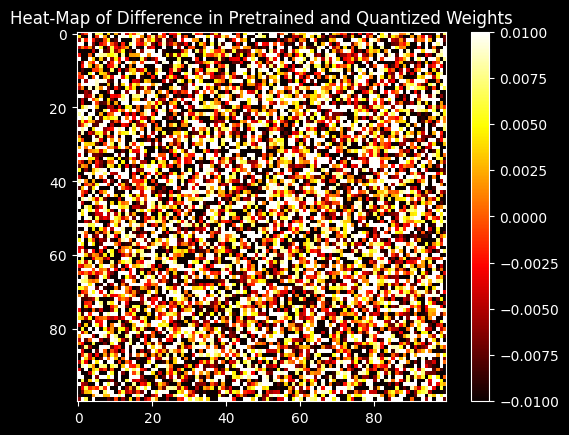

In [73]:
print('Mean Error in the matrix: ', np.mean(Error_weight))

plt.imshow(Error_weight[:100, :100], cmap='hot', interpolation='nearest', vmin= -0.01, vmax= 0.01)
plt.colorbar()
plt.title('Heat-Map of Difference in Pretrained and Quantized Weights')
plt.show()

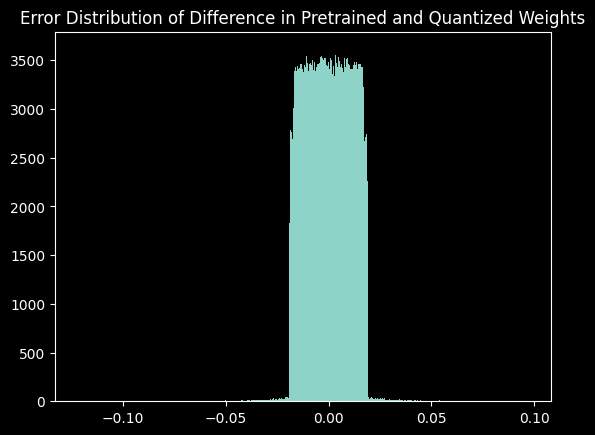

In [74]:
plt.hist(Error_weight.flatten(), bins = 1000)
plt.title('Error Distribution of Difference in Pretrained and Quantized Weights')
plt.xlabel('Magnitude of Error')
plt.ylabel('Frquency')
plt.show()

In [113]:
Error_weight =  weight - quantized_weights 
k = 100

P, L, U = scipy.linalg.lu(Error_weight)
L_k = L[:,:k]
U_k = U[:k,:]


A = torch.tensor(L_k, requires_grad=True, dtype=torch.double)
B = torch.tensor(U_k, requires_grad=True, dtype=torch.double)
We_true = torch.tensor(Error_weight, dtype=torch.double)

N =100
learning_rate = 0.001
optimiser = optim.Adam([A, B], learning_rate)

for i in range(N):
    We_aprox= torch.matmul(A,B)
    Error_loss = torch.sum((We_true - We_aprox)**2)
    print("Difference in loss: ", Error_loss.item())
    Error_loss.backward()

    optimiser.step()
    optimiser.zero_grad()



Difference in loss:  665.301602809229
Difference in loss:  556.3569721552554
Difference in loss:  474.5606846648602
Difference in loss:  413.2747480285108
Difference in loss:  366.60254538193254
Difference in loss:  330.0723761241925
Difference in loss:  300.5456210915734
Difference in loss:  275.9218141246805
Difference in loss:  254.84597696601284
Difference in loss:  236.45843810516288
Difference in loss:  220.21274102448325
Difference in loss:  205.75396102843337
Difference in loss:  192.83518656745852
Difference in loss:  181.26919336450578
Difference in loss:  170.90588611053602
Difference in loss:  161.61765082948875
Difference in loss:  153.28663402558584
Difference in loss:  145.8006788664059
Difference in loss:  139.05637390792668
Difference in loss:  132.9612611844162
Difference in loss:  127.43269050093221
Difference in loss:  122.39795256274326
Difference in loss:  117.79682530228247
Difference in loss:  113.58157349022522
Difference in loss:  109.71338946104639
Difference

In [115]:
W_tensor = torch.tensor(quantized_weights, dtype=torch.double)
ori_W_tensor = torch.tensor(weight, dtype=torch.double)

with torch.no_grad():

    X_sample = torch.tensor(np.random.randn(1, weight.shape[1]))
    
    Y_tensor = forwPass(X_sample, ori_W_tensor)
    Quant_Y_tensor = forwPass(X_sample, W_tensor)
    Quant_Y_Optim_tensor = forwPass(X_sample, W_tensor) + forwPass(X_sample, torch.matmul(A, B))

    Optim_Quant_Loss_WRT_Quant = l2loss_tensor(Quant_Y_Optim_tensor, Quant_Y_tensor)
    Optim_Quant_Loss_WRT_Ori = l2loss_tensor(Quant_Y_Optim_tensor, Y_tensor)
    Quant_Loss_WRT_Ori = l2loss_tensor(Quant_Y_tensor, Y_tensor)

print("Method 4 Output WRT Quant Output: ", Optim_Quant_Loss_WRT_Quant)
print("Method 4 Output WRT Original Output: ", Optim_Quant_Loss_WRT_Ori)
print("Quant Loss WRT Original Output: ", Quant_Loss_WRT_Ori)

Method 4 Output WRT Quant Output:  tensor(12.8159, dtype=torch.float64)
Method 4 Output WRT Original Output:  tensor(63.2830, dtype=torch.float64)
Quant Loss WRT Original Output:  tensor(76.5565, dtype=torch.float64)
